In [557]:
import pandas as pd
import plotly.express as px
import plotly.io as pio
import random
pio.templates.default = 'simple_white'
import datetime
import tqdm
import numpy as np

### Modelling retention

### Modelling new users

In [558]:
dates = pd.date_range('2021-01-01', '2024-03-15', freq = 'w')
len(dates)

167

In [559]:
weeks_adjustments = {
    '53': 0.7,
    '52': 0.7,
    '51': 0.8,
    '50': 0.9,
    '19': 0.95,
    '20': 0.9,
    '21': 0.85,
    '22': 0.8,
    '23': 0.75,
    '24': 0.7,
    '25': 0.7,
    '26': 0.7,
    '27': 0.7,
    '28': 0.7,
    '29': 0.7,
    '30': 0.7,
    '31': 0.8,
    '32': 0.85,
    '33': 0.9,
    '34': 0.95,
    '35': 1,
    '36': 1.1,
    '37': 1.15,
    '38': 1.2,
    '39': 1.15,
    '40': 1.1,
    '41': 1.05
}

In [560]:
new_users_df = pd.DataFrame()
new_users_df['date'] = dates
new_users_df['x'] = range(new_users_df.shape[0])

new_users_df['trend'] = new_users_df.x.map(
    lambda x: 1/(0.0036 + (x + 1) ** -1.01)
)
new_users_df.drop('x', axis = 1, inplace = True)

new_users_df['week_number'] = new_users_df.date.map(
    lambda x: datetime.datetime.strftime(x, '%V')
)


new_users_df['year'] = new_users_df.date.map(
    lambda x: x.year
)


def get_new_users(trend, week_num):
    if week_num not in weeks_adjustments:
        return int(round(np.random.normal(1, 0.05)*trend))

    return int(round(np.random.normal(1, 0.05)*trend * weeks_adjustments[week_num]))

new_users_df['new_users'] = list(map(
    get_new_users,
    new_users_df.trend,
    new_users_df.week_number
))

In [561]:
new_users_df

,date,trend,week_number,year,new_users
0,2021-01-03,0.996413,53,2021,1
1,2021-01-10,1.999415,01,2021,2
2,2021-01-17,3.000378,02,2021,3
3,2021-01-24,3.997471,03,2021,4
4,2021-01-31,4.989848,04,2021,5
...,...,...,...,...,...
162,2024-02-11,106.041223,06,2024,113
163,2024-02-18,106.446508,07,2024,106
164,2024-02-25,106.849910,08,2024,114
165,2024-03-03,107.251440,09,2024,105


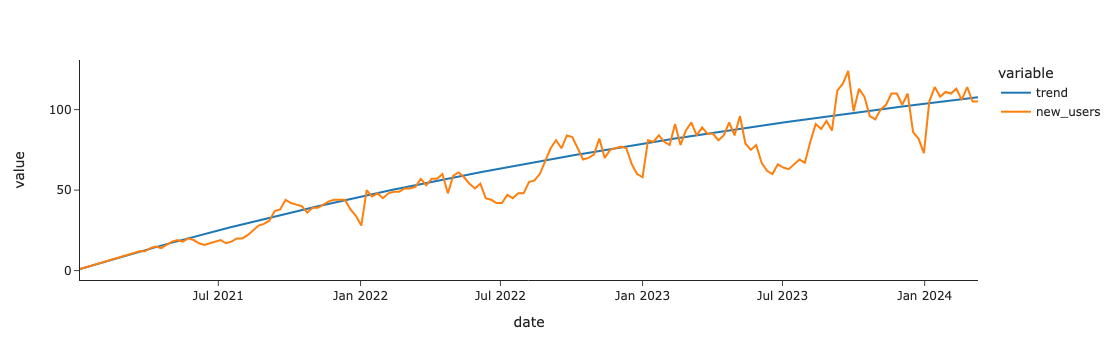

In [562]:
px.line(new_users_df.set_index('date')[['trend', 'new_users']])

### Modelling data

In [563]:
def get_retention(a, b, c, d, periods):
    return  a + 1./(b + c*periods ** d)

def get_retention_same_event(a, c, d, periods):
    b = 1./(1 - a)
    return get_retention(a, b, c, d, periods)

sample_df = pd.DataFrame()
sample_df['periods'] = range(30)

/var/folders/7v/1ln722x97kd8bchgxpmdkynw0000gn/T/ipykernel_37923/116024509.py:16: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



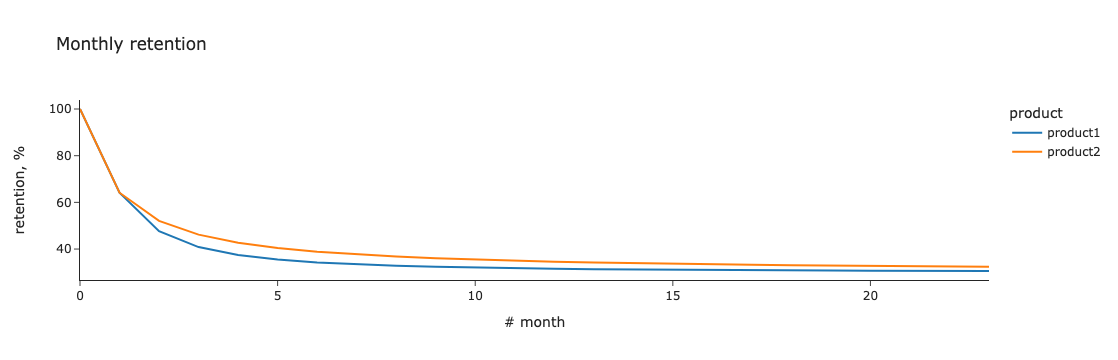

In [564]:
sample_df = pd.DataFrame()
sample_df['periods'] = range(24)

product_coefs = [
    (0.3, 1.5, 1.5),
    (0.3, 1.5, 1.05),
]

for i in range(len(product_coefs)):
    sample_df['product' + str(i + 1)] = sample_df.periods.map(
        lambda x: get_retention_same_event(product_coefs[i][0], product_coefs[i][1],
                                           product_coefs[i][2], x)
    )
    
sample_df = sample_df.set_index('periods')
px.line(sample_df.applymap(lambda x: None if x < 0.01 else 100*x).loc[0:],
       title = 'Monthly retention',
       labels = {'value': 'retention, %',
                'periods': '# month',
                'variable': 'product'})

In [565]:
period = 0
user_id = 1

In [566]:
new_users_df.head()

,date,trend,week_number,year,new_users
0,2021-01-03,0.996413,53,2021,1
1,2021-01-10,1.999415,01,2021,2
2,2021-01-17,3.000378,02,2021,3
3,2021-01-24,3.997471,03,2021,4
4,2021-01-31,4.989848,04,2021,5


In [567]:
np.random.normal(3, 1)

2.181966851502414

In [568]:
import random

random.choices(['nerd', 'busy', 'average'], [0.2, 0.3, 0.5])[0]

'busy'

In [569]:
last_id = 1
user_list = []

for rec in tqdm.tqdm(new_users_df.to_dict('records')):
    for _ in range(rec['new_users']):
        user_list.append(
            {
                'id': last_id,
                'cohort': rec['date'].strftime('%Y-%m-%d'),
                'user_segment': random.choices(['nerd', 'busy', 'average'], [0.2, 0.3, 0.5])[0]
            }
        )
        last_id += 1

100%|██████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 3365.24it/s]


In [570]:
len(user_list), new_users_df.new_users.sum()

(9913, 9913)

In [571]:
def get_retention_est_rel(periods):
    a, c, d = 0.3, 1.5, 1.05
    b = 1./(1 - a)
    return get_retention(a, b, c, d, periods)/get_retention(a, b, c, d, periods - 1)


def get_num_lessons(user_segment, week_num):
    if week_num in weeks_adjustments:
        coef = weeks_adjustments[week_num]
    else:
        coef = 1
    if user_segment == 'nerd':
        est = np.random.normal(4*coef, 2)
    elif user_segment == 'busy':
        est = np.random.normal(1*coef, 1)
    else:
        est = np.random.normal(2*coef, 1)

    if est < 0:
        return 0
    return int(est)

In [573]:
tmp_data = []
for rec in tqdm.tqdm(user_list):
    # first lesson
    total_lessons = 1
    tmp_data.append(
        {
            'user_id': rec['id'],
            'cohort': rec['cohort'],
            'user_segment': rec['user_segment'],
            'date': rec['cohort'],
            'passed_lessons': 1,
            'num_week': 0,
            'total_lessons': total_lessons
        }
    )
    
    
    tmp_dates = pd.date_range(rec['cohort'], '2024-03-15', freq = 'w')
    
    for periods in range(1, len(tmp_dates)):
        if random.random() > get_retention_est_rel(periods):
            break
        
        num_lessons = get_num_lessons(rec['user_segment'], tmp_dates[periods].strftime('%V'))
        if total_lessons + num_lessons > 600:
            break

        total_lessons = total_lessons + num_lessons
        tmp_data.append(
            {
                'user_id': rec['id'],
                'cohort': rec['cohort'],
                'user_segment': rec['user_segment'],
                'date': tmp_dates[periods].strftime('%Y-%m-%d'),
                'passed_lessons': num_lessons,
                'num_week': periods,
                'total_lessons': total_lessons
            }
        )
        

100%|████████████████████████████████████████████████████████████████| 9913/9913 [00:06<00:00, 1539.11it/s]


In [574]:
sim_df = pd.DataFrame(tmp_data)

In [575]:
sim_df.passed_lessons.value_counts(normalize = True)

passed_lessons
1     0.324819
0     0.252879
2     0.217756
3     0.101531
4     0.045671
5     0.028249
6     0.017009
7     0.007872
8     0.002914
9     0.001031
10    0.000234
11    0.000024
12    0.000010
Name: proportion, dtype: float64

In [576]:
sim_df.shape[0]

205533

In [577]:
sim_df = sim_df[sim_df.passed_lessons > 0]
sim_df.shape[0]

153558

In [578]:
stats_df = sim_df.groupby('user_segment').aggregate(
    {'user_id': 'nunique', 'date': 'count', 'passed_lessons': 'sum'})

stats_df['weeks_per_user'] = stats_df.date/stats_df.user_id
stats_df['lessons_per_user'] = stats_df.passed_lessons/stats_df.user_id

In [579]:
stats_df

,user_id,date,passed_lessons,weeks_per_user,lessons_per_user
user_segment,,,,,
average,4907,83277,143856,16.971062,29.316487
busy,2950,30101,39661,10.203729,13.444407
nerd,2056,40180,141499,19.542802,68.822471


In [580]:
user_stats_df = sim_df.groupby(['user_id', 'user_segment'], as_index = False).aggregate(
    {'date': 'nunique', 'passed_lessons': 'sum'}
)

In [581]:
user_stats_df.head()

,user_id,user_segment,date,passed_lessons
0,1,average,7,9
1,2,busy,74,104
2,3,average,10,14
3,4,average,1,1
4,5,average,1,1


In [582]:
user_stats_df.passed_lessons.max()

540

In [583]:
user_stats_df[user_stats_df.passed_lessons >= 600].shape[0]

0

In [584]:
user_stats_df[user_stats_df.passed_lessons >= 600].shape[0]/user_stats_df.shape[0]*100

0.0

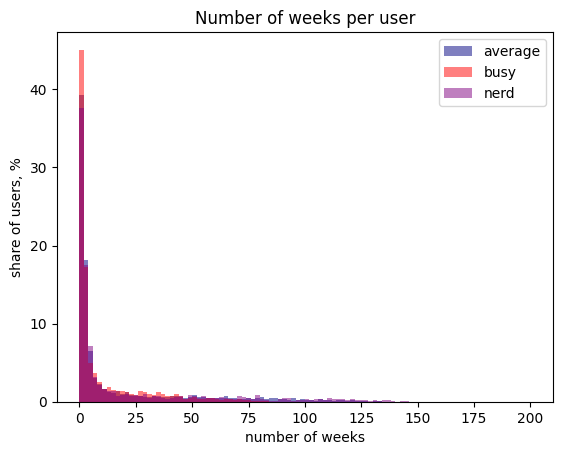

In [585]:
from matplotlib import pyplot

hist_range = [0, 200]
hist_bins = 100
metric = 'date'

pyplot.hist(
    user_stats_df[user_stats_df.user_segment == 'average'][metric].values,
    label = 'average',
    alpha = 0.5, range = hist_range, bins = hist_bins,
    color = 'navy',
    # calculating weights to get normalised histogram
    weights = np.ones_like(user_stats_df[user_stats_df.user_segment == 'average'].index)*100/user_stats_df[user_stats_df.user_segment == 'average'].shape[0]
)

pyplot.hist(
    user_stats_df[user_stats_df.user_segment == 'busy'][metric].values,
    label = 'busy',
    alpha = 0.5, range = hist_range, bins = hist_bins,
    color = 'red',
    # calculating weights to get normalised histogram
    weights = np.ones_like(user_stats_df[user_stats_df.user_segment == 'busy'].index)*100/user_stats_df[user_stats_df.user_segment == 'busy'].shape[0]
)

pyplot.hist(
    user_stats_df[user_stats_df.user_segment == 'nerd'][metric].values,
    label = 'nerd',
    alpha = 0.5, range = hist_range, bins = hist_bins,
    color = 'purple',
    # calculating weights to get normalised histogram
    weights = np.ones_like(user_stats_df[user_stats_df.user_segment == 'nerd'].index)*100/user_stats_df[user_stats_df.user_segment == 'nerd'].shape[0]
)

pyplot.legend(loc = 'upper right')
pyplot.title('Number of weeks per user')
pyplot.xlabel('number of weeks')
pyplot.ylabel('share of users, %')
pyplot.show()

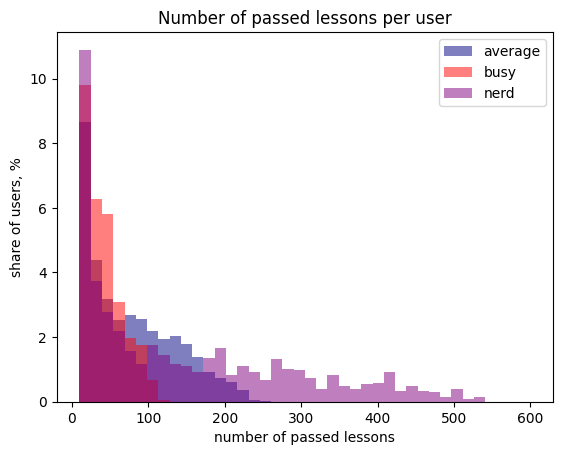

In [586]:
from matplotlib import pyplot

hist_range = [10, 600]
hist_bins = 40
metric = 'passed_lessons'

pyplot.hist(
    user_stats_df[user_stats_df.user_segment == 'average'][metric].values,
    label = 'average',
    alpha = 0.5, range = hist_range, bins = hist_bins,
    color = 'navy',
    # calculating weights to get normalised histogram
    weights = np.ones_like(user_stats_df[user_stats_df.user_segment == 'average'].index)*100/user_stats_df[user_stats_df.user_segment == 'average'].shape[0]
)

pyplot.hist(
    user_stats_df[user_stats_df.user_segment == 'busy'][metric].values,
    label = 'busy',
    alpha = 0.5, range = hist_range, bins = hist_bins,
    color = 'red',
    # calculating weights to get normalised histogram
    weights = np.ones_like(user_stats_df[user_stats_df.user_segment == 'busy'].index)*100/user_stats_df[user_stats_df.user_segment == 'busy'].shape[0]
)

pyplot.hist(
    user_stats_df[user_stats_df.user_segment == 'nerd'][metric].values,
    label = 'nerd',
    alpha = 0.5, range = hist_range, bins = hist_bins,
    color = 'purple',
    # calculating weights to get normalised histogram
    weights = np.ones_like(user_stats_df[user_stats_df.user_segment == 'nerd'].index)*100/user_stats_df[user_stats_df.user_segment == 'nerd'].shape[0]
)

pyplot.legend(loc = 'upper right')
pyplot.title('Number of passed lessons per user')
pyplot.xlabel('number of passed lessons')
pyplot.ylabel('share of users, %')
pyplot.show()

In [587]:
sim_df.to_csv('simulations_students_activity.csv', index = False)

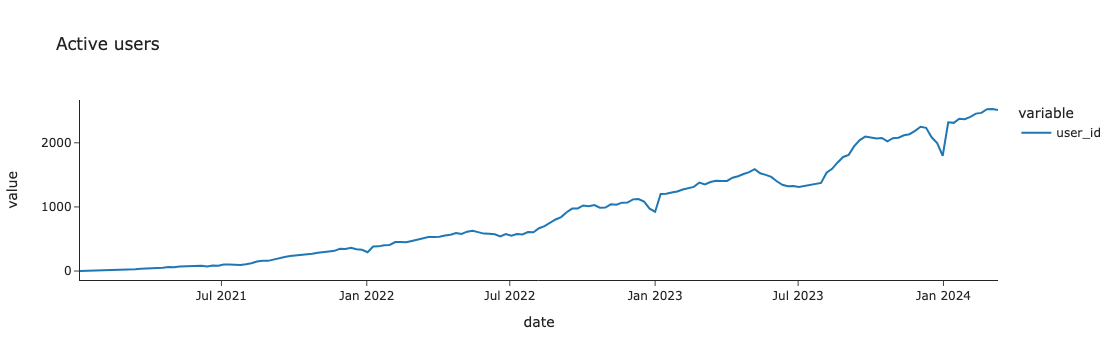

In [588]:
px.line(sim_df.groupby('date')[['user_id']].nunique(), 
       title = 'Active users')

In [589]:
user_id = 1

In [590]:
tmp_data = []

for user_id in sim_df.user_id.unique():
    curr_id = 1
    for rec in sim_df[sim_df.user_id == user_id].to_dict('records'):
        for _ in range(rec['passed_lessons']):
            tmp_data.append(
                {
                    'raw_lesson_num': curr_id,
                    'user_id': user_id,
                    'date': rec['date'],
                    'user_segment': rec['user_segment'],
                    'cohort': rec['cohort']
                }
            )
            curr_id += 1

In [591]:
log_df = pd.DataFrame(tmp_data)

In [594]:
log_df['module'] = log_df.raw_lesson_num.map(lambda x: int(x / 100) + 1)
log_df['lesson_num'] = log_df.raw_lesson_num.map(lambda x: x % 100 + 1)

In [599]:
module_name = {
    1: 'pre-A1',
    2: 'A1',
    3: 'A2',
    4: 'B1',
    5: 'B2',
    6: 'C1'
}


log_df['module'] = log_df.module.map(module_name)

In [600]:
log_df[['user_id', 'date', 'module', 'lesson_num']].to_csv('students_activity.csv', index = False)